['b', 'b_phi', 'Ncoll', 'Ncoll_hard', 'Npart_proj', 'Npart_targ', 'centile', 'runnumber', 'evtnumber', 'filename', 'nHits', 'Hit_E', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_detid', 'nParticles', 'particle_pid', 'particle_energy', 'particle_px', 'particle_py', 'particle_pz', 'particle_vtx_x', 'particle_vtx_y', 'particle_vtx_z', 'particle_track_id', 'particle_primary_id', 'particle_parent_id', 'particle_is_pythia_primary', 'particle_is_embedded', 'particle_charge', 'nRecoClusters', 'reco_cluster_E', 'reco_cluster_x', 'reco_cluster_y', 'reco_cluster_z', 'reco_cluster_t', 'reco_cluster_detid', 'reco_cluster_id', 'reco_cluster_trcluster_id', 'reco_cluster_g4hit_id', 'reco_cluster_g4hit_trkid', 'nTruthClusters', 'truth_cluster_E', 'truth_cluster_x', 'truth_cluster_y', 'truth_cluster_z', 'truth_cluster_t', 'truth_cluster_detid', 'truth_cluster_id', 'truth_cluster_trparticle_track_id', 'nTrackG4Hits', 'track_g4hit_x', 'track_g4hit_y', 'track_g4hit_z', 'track_g4hit_t', 'track_g4hit_E', 'track_

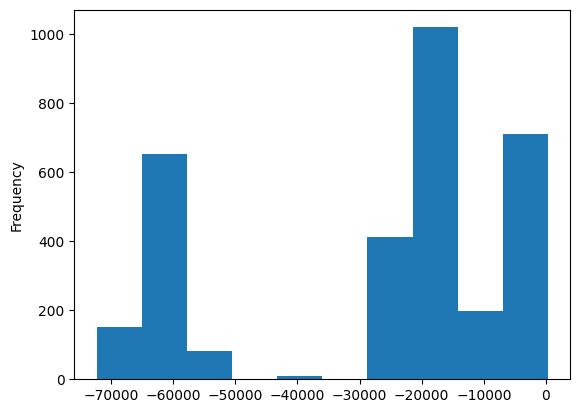

In [ ]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

data_file = "../macro/testout.root"
# data_file = "macro/2025-03-25_pp-mode/testout.root"
event_id = 0  # pick different events
with uproot.open(data_file) as fp:
    print(list(fp['T;1'].keys()))
data = uproot.open(data_file)["T;1"]


def get_clusters(data, event_id):
    cid = data["reco_cluster_id"].array(library="np")[event_id]
    x = data["reco_cluster_x"].array(library="np")[event_id]
    y = data["reco_cluster_y"].array(library="np")[event_id]
    z = data["reco_cluster_z"].array(library="np")[event_id]
    detid = data["reco_cluster_detid"].array(library="np")[event_id]
    ptid = data["reco_cluster_g4hit_trkid"].array(library="np")[event_id]
    df = pd.DataFrame({"cid": cid, "x": x, "y": y, "z": z, "detid": detid, "ptid": ptid})
    return df

clusters = get_clusters(data, event_id)
cid_to_index = {cid: index for index, cid in enumerate(clusters['cid'])}
ptid_to_cids = clusters.groupby('ptid')['cid'].apply(list).to_dict()

print(f"Number of clusters: {len(clusters)}")
print(list(ptid_to_cids.items())[0])
for i in range(10):
    print(list(ptid_to_cids.items())[i])

clusters[clusters["ptid"] < 1e8]["ptid"].plot(kind="hist")

fig = px.scatter(
    clusters,
    x="x",
    y="y",
    color="ptid",
    title="Reco Clusters"
)
fig.update_layout(
    xaxis=dict(
        range=[-80, 80],
        gridcolor='lightgray',
        ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=[-80, 80],
        gridcolor='lightgray',
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
)
fig.update_traces(marker_size=3)
fig.show()

fig = px.scatter_3d(clusters, x='x', y='y', z='z', color='ptid', opacity=0.3)#, symbol='D')
fig.update_traces(marker_size=3)
fig.update_layout(title=f"event {event_id}", width=800, height=800)
camera = dict(
    up=dict(x=1, y=0, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)
fig.update_layout(scene_camera=camera, title=f"EventID={event_id}")
fig.update_layout(legend_traceorder="normal")
fig.show()


Number of seeds: 14
sid                                                     0
cids    [146086612424458257, 146368087401168899, 14664...
x       [-14.833794593811035, -15.570293426513672, -16...
y       [27.645000457763672, 27.89333152770996, 28.114...
z       [-101.13943481445312, -100.91403198242188, -10...
Name: 0, dtype: object


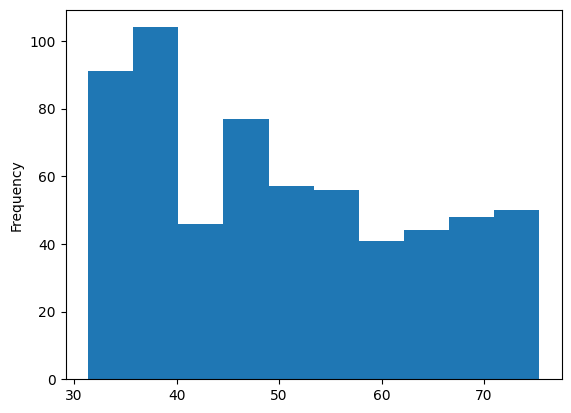

In [7]:
def get_seeds(data, event_id):
    sid = data["tpc_seeds_id"].array(library="np")[event_id]
    cids = data["tpc_seeds_clusters"].array(library="np")[event_id]
    ncid = data["tpc_seeds_nclusters"].array(library="np")[event_id]
    cid_start = data["tpc_seeds_start_idx"].array(library="np")[event_id]
    list_of_cids = [cids[start : start + length] 
                for start, length in zip(cid_start, ncid)]
    lists_of_x = [[clusters.iloc[cid_to_index[cid]]['x'] for cid in cids] for cids in list_of_cids]
    lists_of_y = [[clusters.iloc[cid_to_index[cid]]['y'] for cid in cids] for cids in list_of_cids]
    lists_of_z = [[clusters.iloc[cid_to_index[cid]]['z'] for cid in cids] for cids in list_of_cids]
    df = pd.DataFrame({"sid": sid, "cids": list_of_cids, "x": lists_of_x, "y": lists_of_y, "z": lists_of_z})
    return df

seeds = get_seeds(data, event_id)
print(f"Number of seeds: {len(seeds)}")
print(seeds.iloc[0])


flattened_data = {"seed": [], "x": [], "y": [], "z": [], "r": []}
for irow, row in seeds.iterrows():
    # if irow % 100  != 0:
    #     continue
    for x_val, y_val, z_val in zip(row["x"], row["y"], row["z"]):
        flattened_data["seed"].append(row["sid"])
        flattened_data["x"].append(x_val)
        flattened_data["y"].append(y_val)
        flattened_data["z"].append(z_val)
        flattened_data["r"].append(np.sqrt(x_val**2 + y_val**2))

df_flat = pd.DataFrame(flattened_data)
df_flat["r"].plot(kind="hist")

fig = px.scatter(
    df_flat,
    x="x",
    y="y",
    color="seed",
    title="Seed Clusters"
)
fig.update_layout(
    xaxis=dict(
        range=[-80, 80],
        gridcolor='lightgray',
        ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=[-80, 80],
        gridcolor='lightgray',
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
)
fig.update_traces(marker_size=3)
fig.show()

fig = px.scatter_3d(
    df_flat,
    x="x",
    y="y",
    z="z",
    color="seed",
    title="Seed Clusters"
)
fig.update_traces(marker_size=3)
fig.update_layout(scene_camera=dict(
    eye=dict(x=0, y=0, z=2)
))
fig.show()

In [45]:
def get_particles(data, event_id):
    ppid = data["particle_pid"].array(library="np")[event_id]
    ptid = data["particle_track_id"].array(library="np")[event_id]
    cids = [ptid_to_cids.get(p, [])  for p in ptid]
    lists_of_x = [[clusters.iloc[cid_to_index[cid]]['x'] for cid in cids] for cids in cids]
    lists_of_y = [[clusters.iloc[cid_to_index[cid]]['y'] for cid in cids] for cids in cids]
    lists_of_z = [[clusters.iloc[cid_to_index[cid]]['z'] for cid in cids] for cids in cids]
    px = data["particle_px"].array(library="np")[event_id]
    py = data["particle_py"].array(library="np")[event_id]
    pz = data["particle_pz"].array(library="np")[event_id]
    pt = [np.sqrt(px**2 + py**2) for px, py in zip(px, py)]
    df = pd.DataFrame({"ptid": ptid, "ppid": ppid, "pt": pt, "pz": pz, "cids": cids, "x": lists_of_x, "y": lists_of_y, "z": lists_of_z})
    # df = df[df['ptid'] > 0]
    df = df[df['pt'] > 0.1]
    df = df[df['cids'].apply(len) > 30]
    charge_stable_ppids = [13, -13, 11, -11, 211, -211, 321, -321, 2212, -2212]
    df = df[df['ppid'].isin(charge_stable_ppids)]
    return df
particles = get_particles(data, event_id)

print(f"Number of particles: {len(particles)}")
for i in range(len(particles)):
    print(f"ptid: {particles.iloc[i]['ptid']}, pt: {particles.iloc[i]['pt']}, pz: {particles.iloc[i]['pz']}, ppid: {particles.iloc[i]['ppid']}, cids: {len(particles['cids'].iloc[i])}")

# particles['pt'].plot(kind='hist')

# flattened_data = {"ptid": [], "x": [], "y": [], "z": [], "r": []}
# for irow, row in particles.iterrows():
#     # if irow % 100 != 0:
#     #     continue
#     for x_val, y_val, z_val in zip(row["x"], row["y"], row["z"]):
#         flattened_data["ptid"].append(row["ptid"])
#         flattened_data["x"].append(x_val)
#         flattened_data["y"].append(y_val)
#         flattened_data["z"].append(z_val)
#         flattened_data["r"].append(np.sqrt(x_val**2 + y_val**2))

# df_flat = pd.DataFrame(flattened_data)
# df_flat["r"].plot(kind="hist")

# fig = px.scatter(
#     df_flat,
#     x="x",
#     y="y",
#     color="ptid",
#     title="Particle Clusters"
# )
# fig.update_layout(
#     xaxis=dict(range=[-80, 80]),
#     yaxis=dict(
#         scaleanchor="x",
#         scaleratio=1,
#         range=[-80, 80]
#     )
# )
# fig.update_traces(marker_size=3)
# fig.show()

# fig = px.scatter_3d(
#     df_flat,
#     x="x",
#     y="y",
#     z="z",
#     color="ptid",
#     title="Particle Clusters"
# )
# fig.update_traces(marker_size=3)
# fig.update_layout(scene_camera=dict(
#     eye=dict(x=0, y=0, z=2)
# ))
# fig.show()


Number of particles: 1031
ptid: 4, pt: 0.3970330044728815, pz: 0.48169639706611633, ppid: -211, cids: 60
ptid: 8, pt: 0.4708591474150304, pz: 0.058605439960956573, ppid: -2212, cids: 47
ptid: 18, pt: 0.5478150738125365, pz: 0.7786747217178345, ppid: 211, cids: 44
ptid: 26, pt: 0.6563320807496025, pz: -0.43705472350120544, ppid: 211, cids: 50
ptid: 28, pt: 0.6819013800035416, pz: 0.23200182616710663, ppid: 211, cids: 42
ptid: 30, pt: 0.2799708199964224, pz: -0.1833944171667099, ppid: 211, cids: 51
ptid: 32, pt: 0.3791270261572669, pz: -0.03970538079738617, ppid: 211, cids: 42
ptid: 33, pt: 0.23245445536454615, pz: 0.1295301616191864, ppid: -211, cids: 61
ptid: 35, pt: 0.5286179929167664, pz: 0.7302573323249817, ppid: 211, cids: 36
ptid: 36, pt: 0.18488271799286712, pz: 0.1512858122587204, ppid: -211, cids: 64
ptid: 39, pt: 0.3985824338171021, pz: -0.32320719957351685, ppid: 211, cids: 37
ptid: 49, pt: 0.6581916777307897, pz: 1.1645362377166748, ppid: -321, cids: 32
ptid: 50, pt: 0.70342

In [46]:
def match_particles_to_seeds_optimized(particles, seeds, ncommon):
    """
    For each particle in the particles DataFrame, find if there is at least one
    seed in the seeds DataFrame sharing at least `ncommon` cids. If found,
    store the particle's pt in a list.

    Parameters:
        particles (pd.DataFrame): Must have columns 'pt' and 'cids'.
        seeds (pd.DataFrame): Must have columns 'sid' and 'cids'.
        ncommon (int): Threshold for minimum shared cids.

    Returns:
        list: List of particle pt's that matched at least one seed.
    """

    # Precompute sets of cids for each seed to avoid repeated set() calls
    # We'll just store a list of (sid, set_of_cids) so we can iterate quickly.
    seed_cid_sets = []
    for _, seed_row in seeds.iterrows():
        seed_cid_sets.append( (seed_row['sid'], set(seed_row['cids'])) )

    matched_pts = []

    # Helper function to short-circuit intersection counting
    def has_ncommon_or_more(set_a, set_b, n):
        """
        Return True if sets `set_a` and `set_b` share at least `n` elements,
        checking incrementally so we can stop early.
        """
        # Always iterate over the smaller set to reduce lookups
        if len(set_a) <= len(set_b):
            smaller, larger = set_a, set_b
        else:
            smaller, larger = set_b, set_a

        count = 0
        for item in smaller:
            if item in larger:
                count += 1
                if count >= n:
                    return True
        return False

    # For each particle, check if at least one seed matches
    for _, particle_row in particles.iterrows():
        particle_cids = set(particle_row['cids'])
        for sid, seed_set in seed_cid_sets:
            if has_ncommon_or_more(particle_cids, seed_set, ncommon):
                matched_pts.append(particle_row['pt'])
                break  # no need to check further seeds once matched

    return matched_pts

# Example usage:
# Assuming `particles` and `seeds` are already defined from get_particles() and get_seeds():
ncommon = 4  # change to your desired threshold
matched_pt = match_particles_to_seeds_optimized(particles, seeds, ncommon)
all_pt = particles['pt'].tolist()
print(f"All {len(all_pt)} matched: {len(matched_pt)}")

All 1031 matched: 556


bin_edges: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]


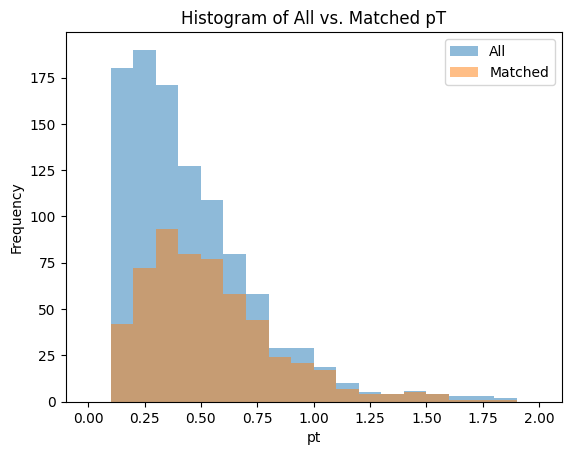

bin_counts_all: [  0 180 190 171 127 109  80  58  29  29  19  10   5   4   6   4   3   3
   2   0], bin_counts_matched: [ 0 42 72 93 80 77 58 44 24 21 17  7  4  4  5  4  1  1  1  0]
bin_edges: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
efficiency: [0.         0.23333333 0.37894737 0.54385965 0.62992126 0.70642202
 0.725      0.75862069 0.82758621 0.72413793 0.89473684 0.7
 0.8        1.         0.83333333 1.         0.33333333 0.33333333
 0.5        0.        ]


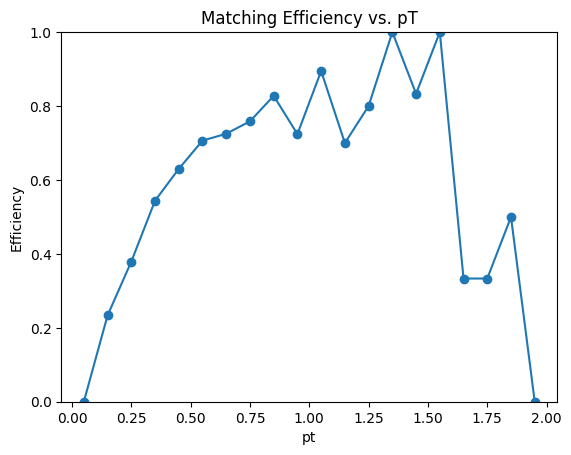

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you already have these:
# all_pt = particles['pt'].tolist()
# matched_pt = match_particles_to_seeds_optimized(particles, seeds, ncommon)

# 1) Plot histograms of all_pt and matched_pt
bin_edges = np.linspace(0, 2, 21)  # Define bin edges
print(f"bin_edges: {bin_edges}")
plt.hist(all_pt, bins=bin_edges, alpha=0.5, label='All')
plt.hist(matched_pt, bins=bin_edges, alpha=0.5, label='Matched')
plt.xlabel('pt')
plt.ylabel('Frequency')
plt.title('Histogram of All vs. Matched pT')
plt.legend()
plt.show()

# 2) Compute Efficiency per bin
bin_counts_all, bin_edges = np.histogram(all_pt, bins=bin_edges)
bin_counts_matched, _     = np.histogram(matched_pt, bins=bin_edges)
print(f"bin_counts_all: {bin_counts_all}, bin_counts_matched: {bin_counts_matched}")
print(f"bin_edges: {bin_edges}")

# Avoid divide-by-zero by checking bin_counts_all before dividing
efficiency = np.zeros_like(bin_counts_all, dtype=float)
mask = bin_counts_all > 0
efficiency[mask] = bin_counts_matched[mask] / bin_counts_all[mask]
print(f"efficiency: {efficiency}")

# 3) Plot Efficiency vs. pT
# Use the bin centers for plotting
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_centers, efficiency, marker='o', linestyle='-')
plt.xlabel('pt')
plt.ylabel('Efficiency')
plt.title('Matching Efficiency vs. pT')
plt.ylim(0, 1)  # Efficiency ranges from 0 to 1
plt.show()
